<a href="https://colab.research.google.com/github/Walid-Ahmed/Google-Tensorflow-Certificate/blob/master/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Important Functions

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Time Series Sample Models

In [4]:
window_size=20
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=[window_size]))
model.summary()
model.compile(loss="mse" ,  optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [5]:
window_size=20
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))


## Creating Sample Dataset

The next code block will set up the time series with seasonality, trend and a bit of noise. 

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    #Using numpy.where(), elements of the NumPy array ndarray that satisfy the conditions can be replaced or performed specified processing.
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    print("season_time:",season_time)
    print(len(season_time))
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level





In [10]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
#series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

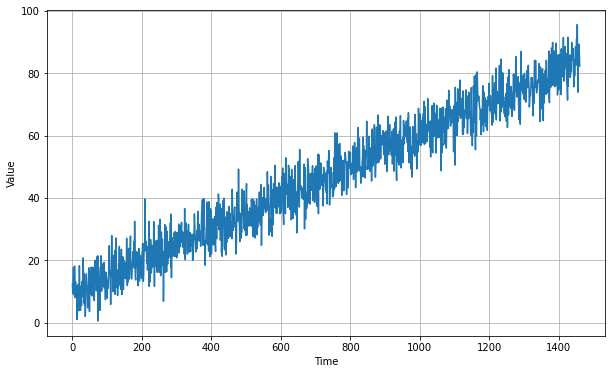

In [11]:
# Create the series
series = baseline + trend(time, slope) 
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

season_time: [0.         0.00273973 0.00547945 ... 0.99452055 0.9972603  0.        ]
1461


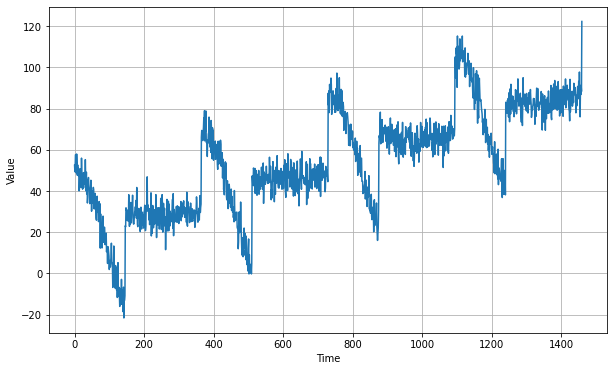

In [12]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

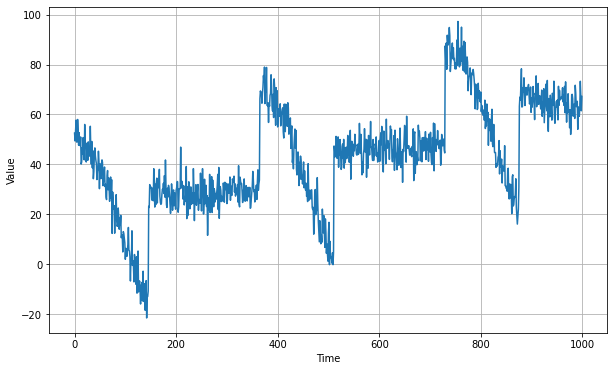

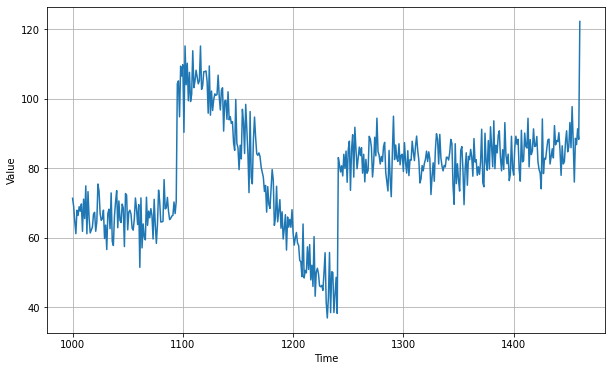

In [ ]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Naive Forecast

In [ ]:
naive_forecast = series[split_time - 1:-1]

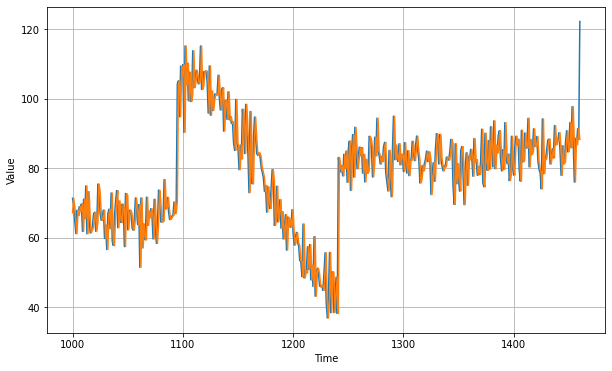

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

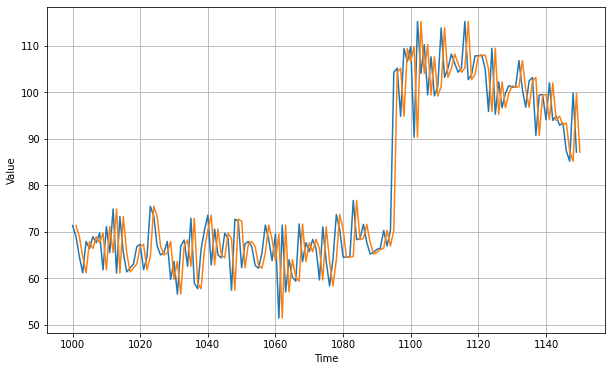

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.9379086


That's our baseline, now let's try a moving average:

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

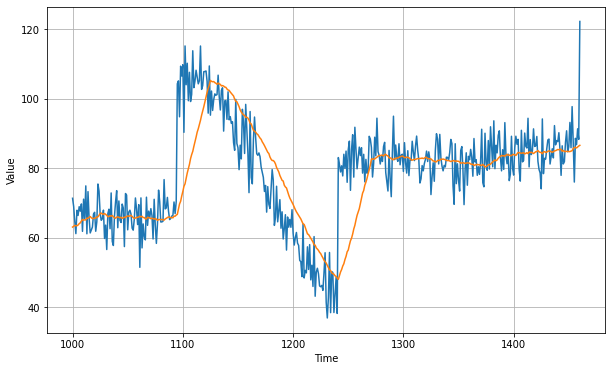

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

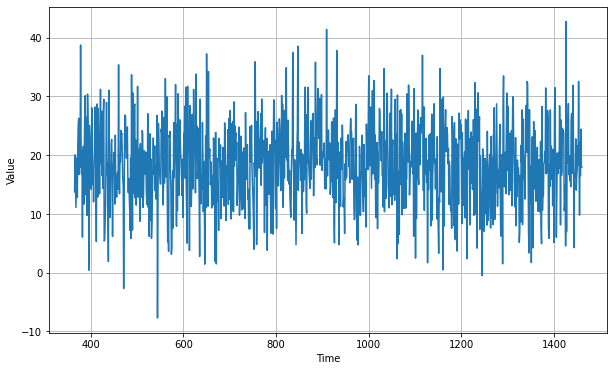

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

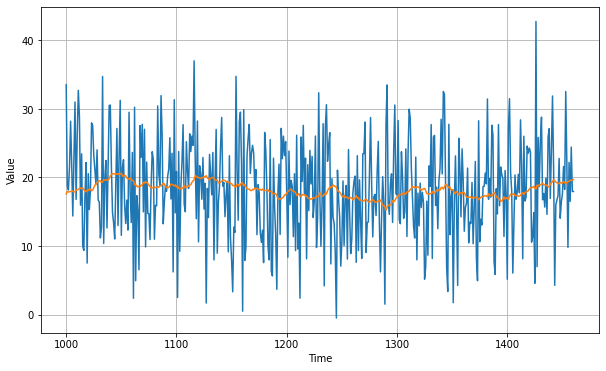

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

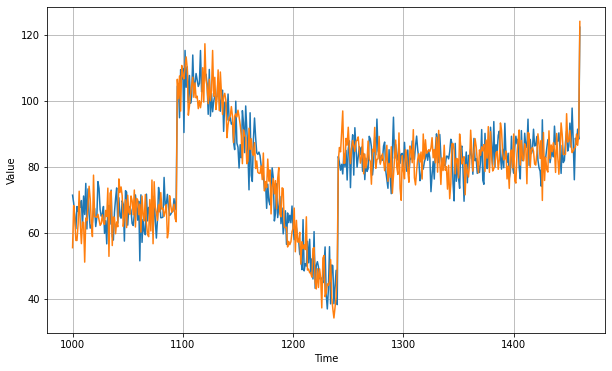

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973656
5.8393106


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

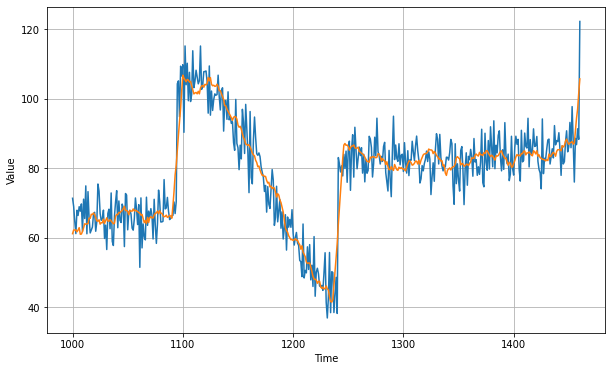

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.45226
4.569442


## Preparing data for time series

In [13]:
dataset = tf.data.Dataset.range(10)
for val in dataset: # val is a tensor of dtype=int64
   print(val.numpy()) #converts a Tensor to a numpy array


0
1
2
3
4
5
6
7
8
9


In [14]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)  # dataset is of type <class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
for window_dataset in dataset:   #window_dataset of type <_VariantDataset shapes: (), types: tf.int64>
  for val in window_dataset:
    print(val.numpy(), end=" ")  #end is used to that no new line is inserted
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [15]:
# Adding drop_remainder=True so that  all windows will be of size 5, others will be ignored
dataset = tf.data.Dataset.range(10) 
dataset = dataset.window(5, shift=1, drop_remainder=True) # dataset is of type <class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


flat_map method of tf.data.Dataset flattens the dataset and maps the function given in method argument across the dataset. Function provided in argument must return a dataset object.

In [16]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)  #window_dataset of type <_VariantDataset shapes: (), types: tf.int64>
dataset = dataset.flat_map(lambda window: window.batch(5)) #dataset of type <FlatMapDataset shapes: (None,), types: tf.int64>
for window in dataset:    # window of type <class 'tensorflow.python.framework.ops.EagerTensor'>
  print(window.numpy())


[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [17]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5)) #dataset of type <FlatMapDataset shapes: (None,), types: tf.int64>
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [19]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) #dataset is of type <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
dataset = dataset.shuffle(buffer_size=100)# a buffer size greater than or equal to the full size of the dataset is required.
for x,y in dataset:
  print(x.numpy(), y.numpy())


[0 1 2 3] [4]
[5 6 7 8] [9]
[1 2 3 4] [5]
[3 4 5 6] [7]
[2 3 4 5] [6]
[4 5 6 7] [8]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]


In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

x_train=np.arange(start=1, stop=1000)
window_size=4
batch_size=2
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print("----------------------------------------------------------------------")


x =  [[765 766 767 768]
 [131 132 133 134]]
y =  [769 135]
----------------------------------------------------------------------
x =  [[636 637 638 639]
 [371 372 373 374]]
y =  [640 375]
----------------------------------------------------------------------
x =  [[376 377 378 379]
 [628 629 630 631]]
y =  [380 632]
----------------------------------------------------------------------
x =  [[907 908 909 910]
 [302 303 304 305]]
y =  [911 306]
----------------------------------------------------------------------
x =  [[779 780 781 782]
 [751 752 753 754]]
y =  [783 755]
----------------------------------------------------------------------
x =  [[209 210 211 212]
 [863 864 865 866]]
y =  [213 867]
----------------------------------------------------------------------
x =  [[529 530 531 532]
 [667 668 669 670]]
y =  [533 671]
----------------------------------------------------------------------
x =  [[105 106 107 108]
 [640 641 642 643]]
y =  [109 644]
-------------------------------

## Time series prediction using Single layer

In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [36]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # type PrefetchDataset

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=100,verbose=0) # Do not specify the batch_size or Y  as  your data is in the form of datasets

print("Layer weights {}".format(l0.get_weights()))


Layer weights [array([[-0.19580187],
       [-0.12447514],
       [-0.3231185 ],
       [ 0.6159854 ],
       [ 0.1427064 ],
       [-0.2579991 ],
       [-0.02121974],
       [-0.15296918],
       [ 0.20684817],
       [-0.2920173 ],
       [-0.30842718],
       [ 0.41787508],
       [ 0.04105066],
       [ 0.3463543 ],
       [ 0.3637616 ],
       [ 0.29942977],
       [-0.17056291],
       [-0.22511552],
       [ 0.22381599],
       [ 0.42192984]], dtype=float32), array([0.00276831], dtype=float32)]


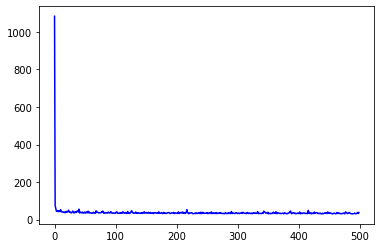

In [ ]:

loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

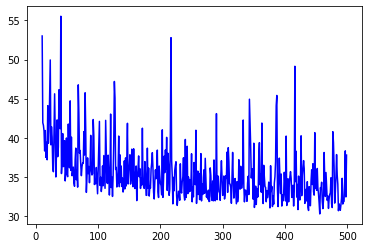

In [ ]:
#Skip first 10 epochs
loss = history.history['loss']
epochs = range(len(loss))
loss=loss[10:]
epochs=epochs[10:]
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

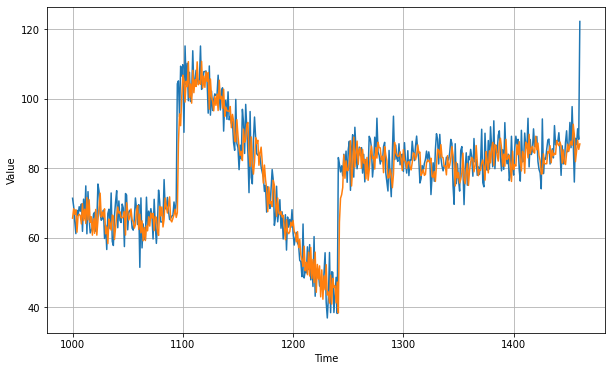

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2199574

## Time series prediction using DNN

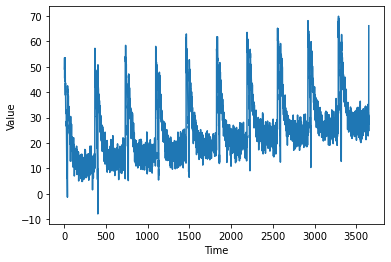

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=100,verbose=0) ## Do not specify the batch_size or Y  as  your data is in the form of datasets


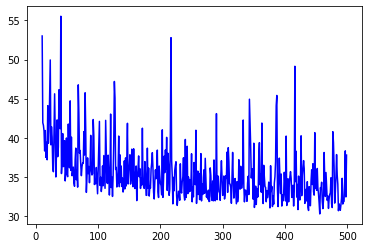

In [ ]:
#Skip first 10 epochs
loss = history.history['loss']
epochs = range(len(loss))
loss=loss[10:]
epochs=epochs[10:]
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

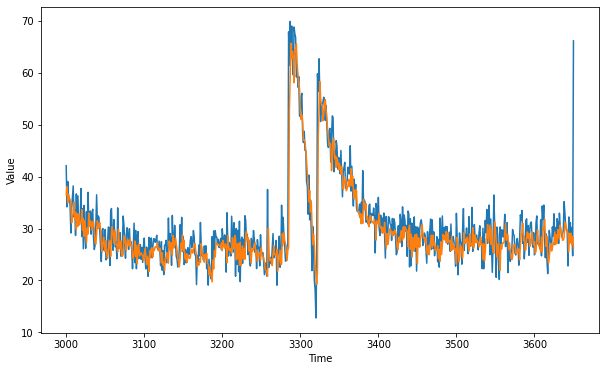

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.1417913

## Time Series Prediction with learning rate tuning

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

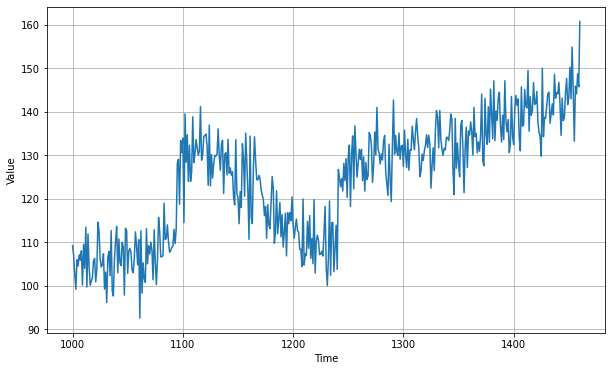

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [45]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=100,verbose=0) ## Do not specify the batch_size or Y  as  your data is in the form of datasets


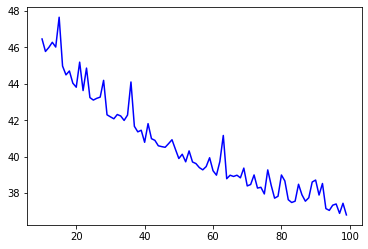

In [ ]:
#Skip first 10 epochs
loss = history.history['loss']
epochs = range(len(loss))
loss=loss[10:]
epochs=epochs[10:]
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

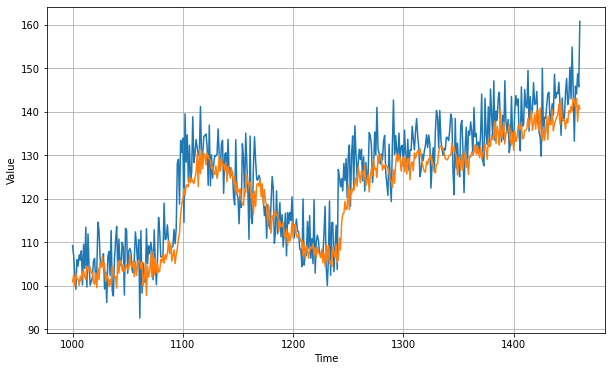

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2833095

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1) ## Do not specify the batch_size or Y  as  your data is in the form of dataset

Epoch 1/100
498/498 [==============================] - 1s 2ms/step - loss: 626.9838
Epoch 2/100
498/498 [==============================] - 1s 2ms/step - loss: 1.1246
Epoch 3/100
498/498 [==============================] - 1s 2ms/step - loss: 1.0882
Epoch 4/100
498/498 [==============================] - 1s 2ms/step - loss: 1.1245
Epoch 5/100
498/498 [==============================] - 1s 2ms/step - loss: 1.1744
Epoch 6/100
498/498 [==============================] - 1s 2ms/step - loss: 1.2129
Epoch 7/100
498/498 [==============================] - 1s 2ms/step - loss: 1.2647
Epoch 8/100
498/498 [==============================] - 1s 2ms/step - loss: 1.3673
Epoch 9/100
498/498 [==============================] - 1s 2ms/step - loss: 1.3188
Epoch 10/100
498/498 [==============================] - 1s 2ms/step - loss: 1.3243
Epoch 11/100
498/498 [==============================] - 1s 2ms/step - loss: 1.4459
Epoch 12/100
498/498 [==============================] - 1s 2ms/step - loss: 1.4880
Epoch 13/10

[4782.77685546875, 523.68896484375, 76.01490783691406, 71.52748107910156, 71.01248931884766, 70.69348907470703, 70.48359680175781, 70.16870880126953, 69.85575866699219, 69.59310913085938, 69.25214385986328, 68.92767333984375, 68.62955474853516, 68.28331756591797, 67.86720275878906, 67.6734848022461, 67.12535095214844, 66.4974136352539, 65.79998016357422, 65.27372741699219, 64.83984375, 64.05936431884766, 64.0812759399414, 62.79664993286133, 62.366641998291016, 61.89685821533203, 61.57840347290039, 60.73545455932617, 61.4334716796875, 58.07639694213867, 57.077674865722656, 56.18857192993164, 55.778045654296875, 54.216033935546875, 53.13166046142578, 52.129276275634766, 50.81858825683594, 49.98103713989258, 49.83218765258789, 47.02381896972656, 46.2024040222168, 45.226680755615234, 46.02461242675781, 45.42757797241211, 41.75369644165039, 45.571128845214844, 43.39181137084961, 41.672447204589844, 41.724666595458984, 39.69034957885742, 38.30315399169922, 37.8940315246582, 48.19027328491211

(1e-08, 0.001, 0.0, 300.0)

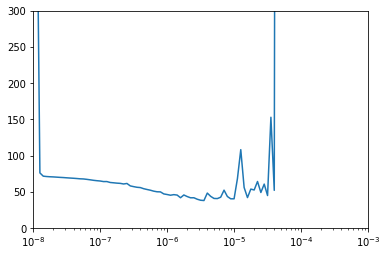

In [ ]:
print(history.history["loss"])

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [ ]:
window_size = 20
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

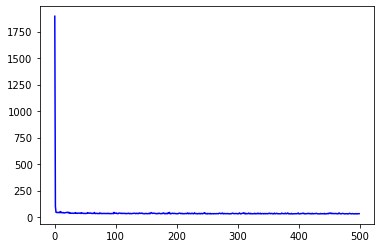

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.77704620361328, 45.82957458496094, 40.90761947631836, 42.5209846496582, 43.090919494628906, 39.06081008911133, 40.11406326293945, 40.12086486816406, 41.961734771728516, 43.8092155456543, 45.333580017089844, 45.60024642944336, 41.083892822265625, 44.913795471191406, 36.761253356933594, 41.62104415893555, 37.205284118652344, 36.11659622192383, 36.48126220703125, 37.40814208984375, 35.885372161865234, 36.30763626098633, 38.031227111816406, 36.482418060302734, 42.19945526123047, 35.71403503417969, 36.46888732910156, 34.947025299072266, 38.06709671020508, 37.665367126464844, 35.90242004394531, 37.75091552734375, 37.925838470458984, 34.238216400146484, 40.60824966430664, 37.71678924560547, 36.833805084228516, 34.27482986450195, 35.19163131713867, 34.945465087890625, 34.88690185546875, 33.938148498535156, 35.768470764160156, 34.811798095703125, 42.14873504638672, 38.47069549560547, 37.170345306396484, 36.677978515625, 39.365108489990234, 36.51288986206055, 36.30011749267578, 34.0027465820

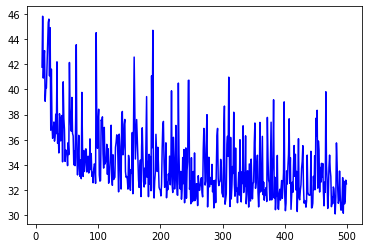

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

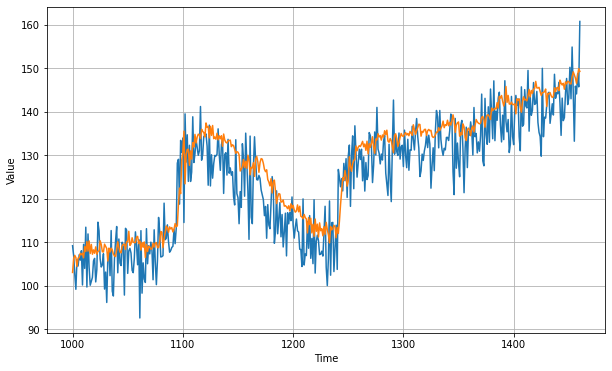

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.352181